### ROUND 10 // Updated Correlation Routine focusing only on the ones we are still checking or have to improve  
#### - ASC Recalculate correlations on the ASC drawing a line in the middle and extracting:
    (i) eddie kinetic energy
    (ii) heat flux x & y
    
#### - Calculate Ekman Pump components separately, then correlate them with isopynal depth

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

# set this to where you want to save figures:
#figdir = '/g/data/v45/akm157/figures/Weddell_connectivity/IAF/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40419/status,
Dashboard: /proxy/40419/status,Workers: 1
Total threads: 1,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36231,Workers: 1
Dashboard: /proxy/40419/status,Total threads: 1
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:39965,Total threads: 1
Dashboard: /proxy/42681/status,Memory: 100.00 GiB
Nanny: tcp://127.0.0.1:41845,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))


#### For that we need first to load inshore box 1 and offshore box 1
#### Load Inshore box 1

In [4]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)


In [5]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

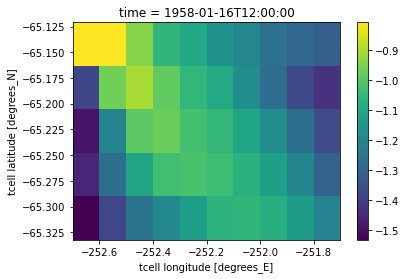

In [6]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [7]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [8]:
#load the variable
temp_400m_za = temp_400m.load()

##test
#np.amin(temp_400m_za)

### Make an annual one so we can evaluate the years chosen

In [9]:
temp_annual = temp_400m_za.groupby('time.year').mean(dim='time')
temp_annual = temp_400m_za.load()

In [19]:
temp_annual_d = detrend_dim(temp_annual,'time')
temp_annual_dr = temp_annual_d.rolling(time=12, center=True).mean()

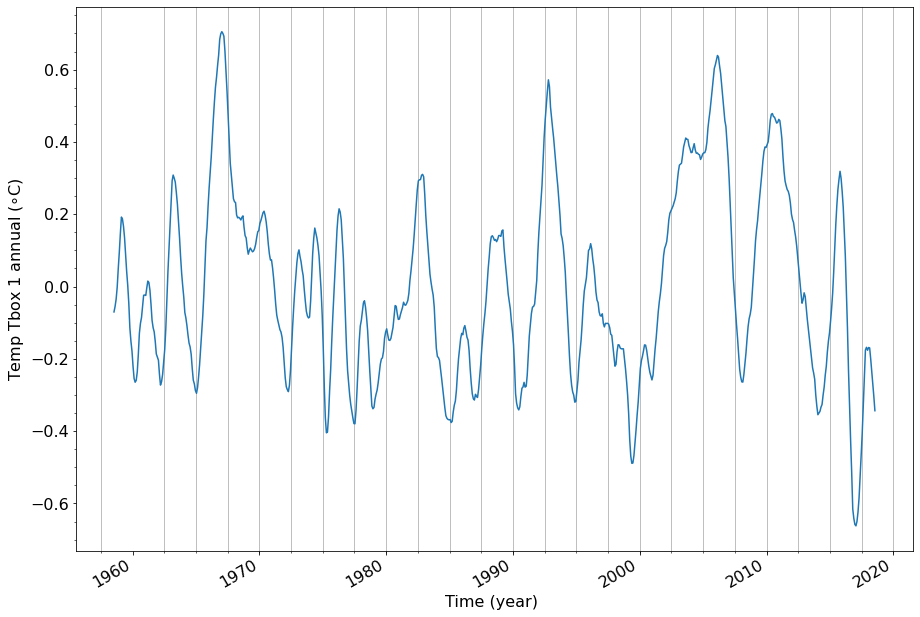

In [42]:
#Confirming the peaks and lows by plotting the year mean
fontsize=16

plt.figure(figsize=(15,10))
temp_annual_dr.plot(color='C0')#,linestyle='--')
plt.ylabel('Temp Tbox 1 annual ($\circ$C)', fontsize=fontsize, color='k')
plt.xlabel(r'Time (year) ', fontsize = fontsize)
plt.tick_params(axis='x',labelsize=fontsize)
plt.tick_params(axis='y', labelcolor='k',labelsize=fontsize)

#this is so i can see minor ticks to aid in counting years
plt.locator_params(axis='x', nbins=5)
plt.minorticks_on()
plt.grid(axis='x',which='minor')
plt.tick_params(axis='y', which='minor', bottom=False) #turns of minor ticks on x


save_results_to = '/g/data/jk72/ns3783'
plt.savefig(save_results_to + 'temp_tbox1_test_annual_new.png', dpi=120,bbox_inches='tight', pad_inches=0.1)


#### LOAD TEMPERATURE FOR BOX 1 offshore, cutting the box with a mask 2000

In [9]:
# load temperature data at 200m (defined on transect):
depth_slice = slice(200, 6000)
# cut the data BOX 1

lon_slice  = slice(-253, -248)
lat_slice  = slice(-67.5, -63)

temp_box1_off = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_box1_off = temp_box1_off.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

In [10]:
# cut the data BOX 1
lon_slice  = slice(-253, -248)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

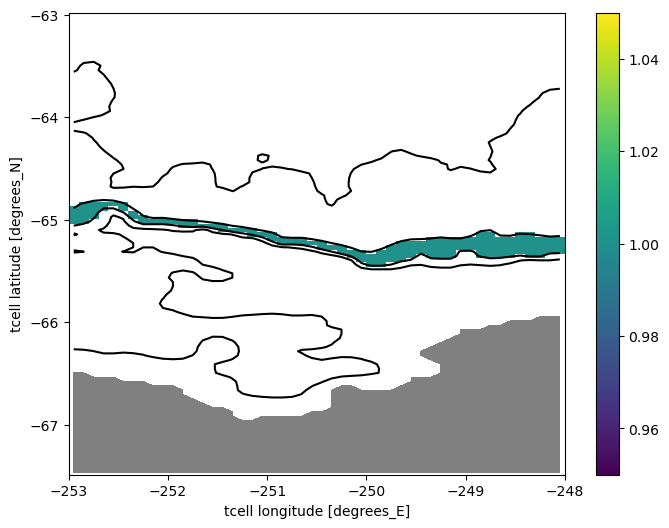

In [11]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[600,1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

save_results_to = '/g/data/jk72/ns3783/Round8/'
#plt.savefig(save_results_to + 'mask_box1_offshore2000.png', dpi=120,bbox_inches='tight', pad_inches=0.1)


In [12]:
#apply the mask
temp_box1_off = temp_box1_off*region_mask
temp_box1_off = temp_box1_off.where(temp_box1_off!=0)


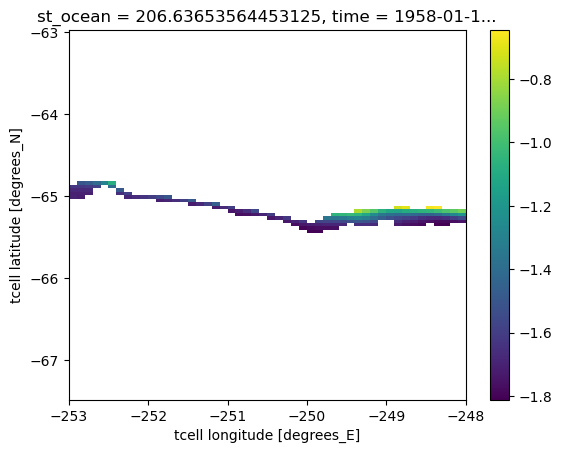

In [13]:
##test if temp is still working before the depth weighting
temp_box1_off[0,0,...].plot()

In [14]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 200
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_box1_off.yt_ocean,'xt_ocean':temp_box1_off.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
#thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))
# Adele comment: replace to use same depth levels as for temp_box1_off:
thickness = thickness.sel(st_ocean=depth_slice)

######## Adele added extra lines here:
# apply mask to thickness:
thickness = thickness*region_mask
thickness = thickness.where(thickness!=0)
########

# multiply by thickness to avg
temp_box1_off = (temp_box1_off*thickness).sum('st_ocean')/thickness.sum('st_ocean')

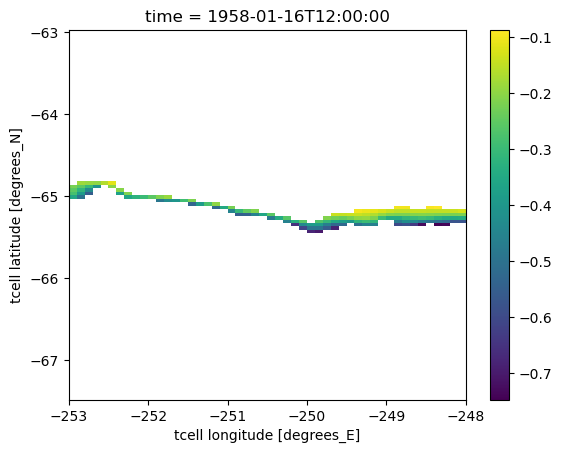

In [15]:
#test after doing the mean depth
temp_box1_off[0,...].plot()

In [16]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

#add mask to area_t otherwise the masked area gets filled with zeros 
area_t = area_t*region_mask

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_box1_off = (temp_box1_off*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum


In [17]:
#load the variable
temp_box1_off2000_za = temp_box1_off.load()

##test
#np.amax(temp_box1_off2000_za) 

#### LOAD EKMAN. This time we will be calculating it with separate components. Instead of the gradient, we will be calculatinf using the shear in X and Y only. Then we end up with ekman transports in x and y. 



In [18]:
#tem que repetir aqui a lat pq esta interferindo no tamanho da matriz no final d calculo
#lon_slice  = slice(-253, -248)
#lon_slice  = slice(-250.5, -248)
#lon_slice  = slice(-254, -252.5)
lon_slice  = slice(-252.5, -250.5) # best
#lon_slice  = slice(-251, -248) 
lat_slice  = slice(-67.5, -63)


# these are the values used by MOM5
sigma = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m
variable='geolat_c'
geolat_c = cc.querying.getvar(iaf_cycle3,'geolat_c',master_session, n=-1).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

f = 2 * sigma * np.sin(np.deg2rad(geolat_c)) # convert lat in radians


In [19]:
# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lon_slice  = slice(-252.5, -250.5) #best
#lon_slice  = slice(-251, -248) 
lat_slice  = slice(-67.5, -63)


first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

tau_x_con = cc.querying.getvar(iaf_cycle3, 'tau_x', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_x_con = tau_x_con.load()

tau_y_con = cc.querying.getvar(iaf_cycle3, 'tau_y', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
tau_y_con = tau_y_con.load()

In [20]:
# database for control simulation:
control = '01deg_jra55v13_ryf9091'

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(control, 'dyu', master_session, n=1)
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
#dyu = dyu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice)

dxu = cc.querying.getvar(control, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
#dxu = dxu.rename(({'nk':'time','ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice)

In [21]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

# fill land with zeros:
tauy_f_con = tau_y_con/f
tauy_f_con = tauy_f_con.fillna(0)
taux_f_con = tau_x_con/f
taux_f_con = taux_f_con.fillna(0)

In [22]:
## ALTERED FROM PREVIOUS TO CALCULATE ISOLATED COMPONENTS

# compute derivatives:
#d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=1))*inverse_dxtn
d_dx_tauyf_con = (tauy_f_con - np.roll(tauy_f_con, 1, axis=2))*inverse_dxtn
#d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=0))*inverse_dyte
d_dy_tauxf_con = (taux_f_con - np.roll(taux_f_con, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
#d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=0))
d_dx_tauyf_con = 0.5 * (d_dx_tauyf_con + np.roll(d_dx_tauyf_con, 1, axis=1))
#d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=1))
d_dy_tauxf_con = 0.5 * (d_dy_tauxf_con + np.roll(d_dy_tauxf_con, 1, axis=2))

# (we won't)compute curl:
#curl_tauf_con = d_dx_tauyf_con - d_dy_tauxf_con
#curl_tauf_con = curl_tauf_con.load()

#load the components for calculating the ekman 
Y = d_dy_tauxf_con.load()
X = d_dx_tauyf_con.load()

s_day=60*60*24 #convert from m/s to m/day
rho0 = 1035. #finish the calculation, could have added above with /f (Page 198 book equation 7.19a and b)
ekman_conY = d_dy_tauxf_con/rho0*s_day
ekman_conX = d_dx_tauyf_con/rho0*s_day

# mask land:
ekman_conY = ekman_conY.where(ekman_conY!=0)
ekman_conX = ekman_conX.where(ekman_conX!=0)

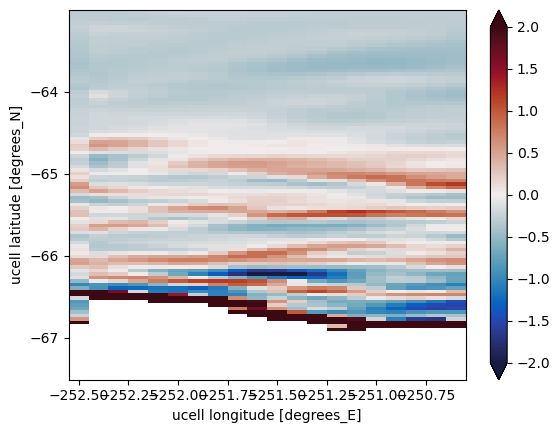

In [23]:
# quick check that this looks ok:
ekman_conY.mean('time').plot(vmin=-2,vmax=2,cmap=cmocean.balance)

In [24]:
# cut the data BOX 1
lon_slice  = slice(-252.3, -250.5) #best
#lon_slice  = slice(-250.8, -248)
lat_slice  = slice(-67.5, -63)

# topography data:
hu = cc.querying.getvar(iaf_cycle3,'hu' , master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)
land_maskU = np.squeeze(hu.values)*0
land_maskU[np.isnan(land_maskU)] = 1
land_maskU = np.where(land_maskU==1,land_maskU,np.nan)

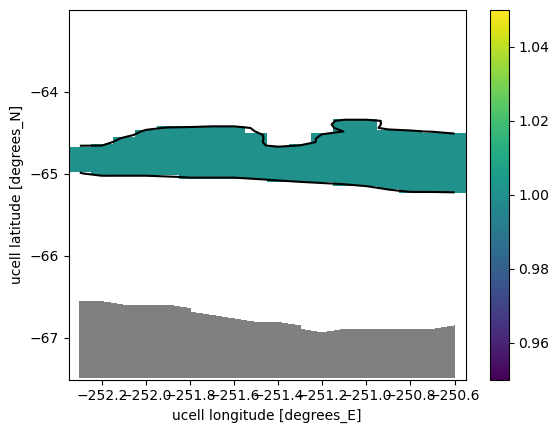

In [25]:
#topography U was loaded previously
# Mask 

# set to 1 everywhere:
region_mask = hu*0 +1

# mask open ocean:
# shelf masking:
#contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U10002000m.npz')
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_U10003000m.npz')
shelf_mask = contour_file['temp_maskU']
yu_ocean = contour_file['yu_ocean']
xu_ocean = contour_file['xu_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yu_ocean', yu_ocean), ('xu_ocean', xu_ocean)])

region_mask = region_mask * shelf_mask.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(hu.xu_ocean,hu.yu_ocean,hu,[1000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(hu.xu_ocean,hu.yu_ocean,land_maskU,colors='grey')

#save_results_to = '/g/data/jk72/ns3783/'
#plt.savefig(save_results_to + 'maskU_box1_offshore.png', dpi=120,bbox_inches='tight', pad_inches=0.1)

In [26]:
#apply the mask
ekman_con_mY = ekman_conY*region_mask
ekman_con_mY = ekman_con_mY.where(ekman_conY!=0)

ekman_con_mX = ekman_conX*region_mask
ekman_con_mX = ekman_con_mX.where(ekman_conX!=0)

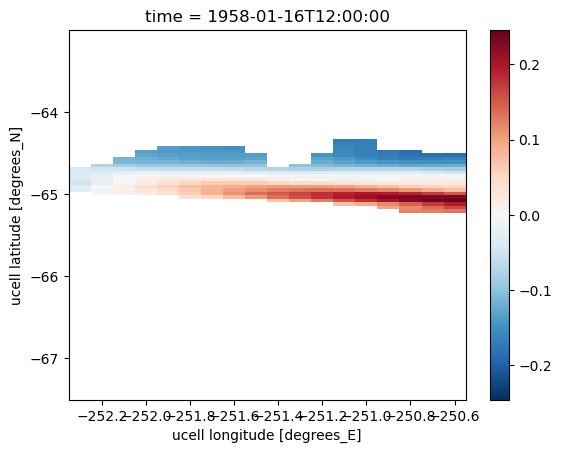

In [27]:
# first time step only:
ekman_con_mY[0,...].plot()

In [28]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)


#add mask to area_t
#NRS added it here because it looks like area weighting also adds zero to masked area instead of nans 
area_u = area_u*region_mask

# sum area:
area_u_sum = area_u.sum('xu_ocean').sum('yu_ocean')

# Apply area weight:
ekman_conY = (ekman_con_mY*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum
ekman_conX = (ekman_con_mX*area_u).sum('xu_ocean').sum('yu_ocean')/area_u_sum

In [29]:
#load the variable
ekman_conY = ekman_conY.load()
ekman_conX = ekman_conX.load()

### Load heat flux X and Y accross ASC longitude line
### ASC with meridional FIRST 

In [30]:
# depth limits chosen based on transects
depth_slice = slice(200, 500)
lat_slice  = -65.3
lon_slice  = slice(-250, -246.5)

heat_y = cc.querying.getvar(iaf_cycle3,'temp_yflux_adv' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
heat_y = heat_y.sel(yu_ocean=lat_slice,method='nearest').sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

##just to get the yt_ocean values
t = cc.querying.getvar(iaf_cycle3,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) -273.15
t = t.sel(yt_ocean=lat_slice,method='nearest').sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

In [31]:
#varlist = cc.querying.get_variables(master_session, iaf_cycle3)
#varlist[varlist['name'].str.lower().str.match('u')]

In [32]:
#rename the odd yu_ocean variable 
heat_y['yu_ocean'] = t['yt_ocean'].values
heat_y = heat_y.rename(({'yu_ocean':'yt_ocean'}))

In [33]:
# cut the data BOX 1

lon_slice  = slice(-253, -251)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16


In [34]:
#heat_y

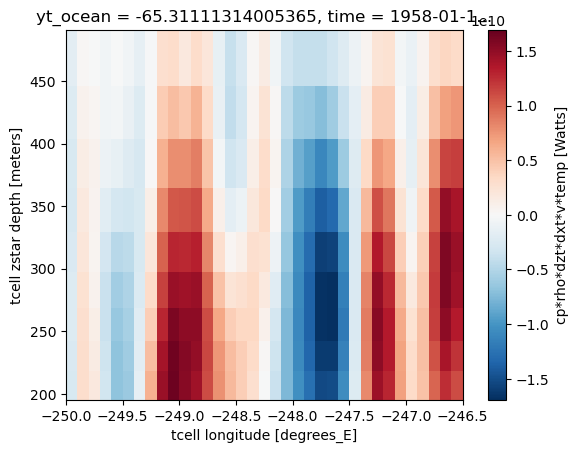

In [35]:
# first time step only:
#heat_y[0,0,...].plot()
heat_y[0,...].plot()

In [36]:
##Because here we need to sum up the whole depth
heat_y = heat_y.sum('st_ocean')

In [37]:
##Because here we need to sum up the whole area to get the real total valeu
heat_y = heat_y.sum('xt_ocean')

In [38]:
#load the variable
asc_heat_y = heat_y.load()

In [39]:
#asc_heat_y

#### ASC HEAT TRANSPORT X

In [40]:
# depth limits chosen based on transects
depth_slice = slice(200, 500)
lat_slice  = -65.2
lon_slice  = slice(-250.9, -247.5)

heat_x = cc.querying.getvar(iaf_cycle3,'temp_xflux_adv' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
heat_x = heat_x.sel(yt_ocean=lat_slice,method='nearest').sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

##just to get the yt_ocean values
t = cc.querying.getvar(iaf_cycle3,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) -273.15
t = t.sel(yt_ocean=lat_slice,method='nearest').sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

In [41]:
#use the xt_ocean from t calculated for heat_y
#rename the odd yu_ocean variable 
heat_x['xu_ocean'] = t['xt_ocean'].values
heat_x = heat_x.rename(({'xu_ocean':'xt_ocean'}))

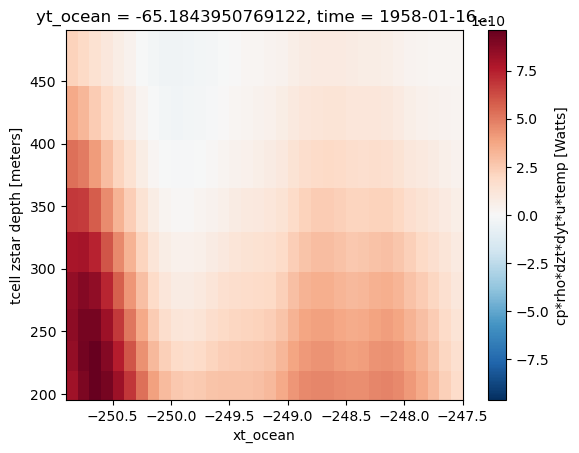

In [42]:
# first time step only:
#heat_y[0,0,...].plot()
heat_x[0,...].plot()

In [43]:
##Because here we need to sum up the whole depth
heat_x = heat_x.sum('st_ocean')

In [44]:
##Because here we need to sum up the whole area to get the real total valeu
heat_x = heat_x.sum('xt_ocean')

In [45]:
#load the variable
asc_heat_x = heat_x.load()

In [46]:
#asc_heat_x

### Make it with speed just one more time

In [47]:
# depth limits chosen based on transects
depth_slice = slice(200, 500)
# set this to the rough region of interest:
#lat_slice  = slice(-65.5,-65.4)
lat_slice  = -65
lon_slice  = slice(-250, -247)

#get U and V general 
u_speed = cc.querying.getvar(iaf_cycle3,'u',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
u_speed = u_speed.sel(yu_ocean=lat_slice,method='nearest').sel(xu_ocean=lon_slice).sel(st_ocean=depth_slice)

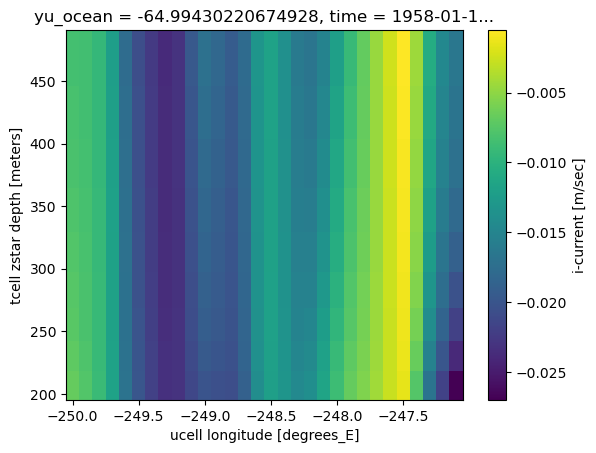

In [48]:
#test after doing the mean depth
#u_speed[0,0,...].plot()
u_speed[0,...].plot()

In [49]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 200
zlevel2 = 500

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'xu_ocean':u_speed.xu_ocean},axis=[1])

# import bathymetry:
hu = cc.querying.getvar(iaf_cycle3,'hu',master_session,n=1)
hu = hu.sel(yu_ocean=lat_slice,method='nearest').sel(xu_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<hu,other=hu)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
u_speed = (u_speed*thickness).sum('st_ocean')/thickness.sum('st_ocean')

In [50]:
#test after doing the mean depth
#u_speed[0,...].plot()


In [51]:
#u_speed

In [52]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_u = cc.querying.getvar('01deg_jra55v13_ryf9091','area_u',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_u = area_u.sel(yu_ocean=lat_slice,method='nearest').sel(xu_ocean=lon_slice)

# sum area:
area_u_sum = area_u.sum('xu_ocean')

# Apply area weight:
u_speed = (u_speed*area_u).sum('xu_ocean')/area_u_sum

In [53]:
#load the variable
u_speed_old_za = u_speed.load()

In [54]:
#u_speed.plot()

#### LOAD MERIDIONAL HEAT FLUX (Y)

In [76]:
# load temperature data at 200m (defined on transect): #crap corr slice(-255, -251) same as before that had teh full domain 253 248
depth_slice = slice(200, 6000)
#lon_slice  = slice(-253, -251) #the best for y
lon_slice  = slice(-254.5, -251) 
lat_slice  = slice(-67.5, -63) 

heat_y = cc.querying.getvar(iaf_cycle3,'temp_yflux_adv' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
heat_y = heat_y.sel(yu_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

##just to get the yt_ocean values
t = cc.querying.getvar(iaf_cycle3,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) -273.15
t = t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

In [77]:
#rename the odd yu_ocean variable 
heat_y['yu_ocean'] = t['yt_ocean'].values
heat_y = heat_y.rename(({'yu_ocean':'yt_ocean'}))


In [78]:
# cut the data BOX 1

lon_slice  = slice(-253, -251)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16


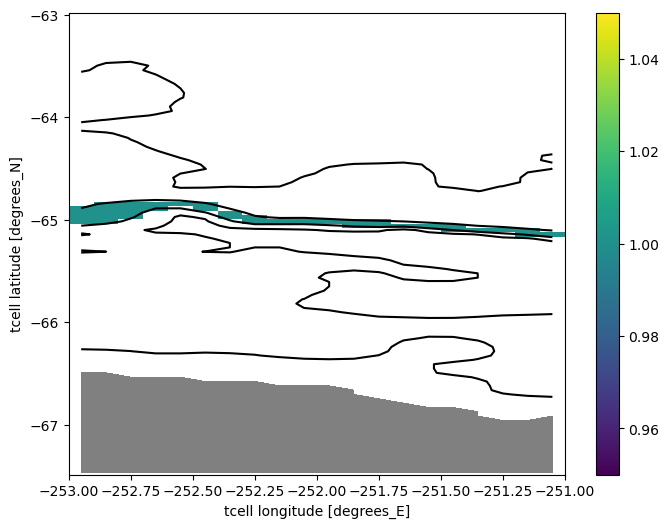

In [79]:
# THE HEAT FLUX VARIABLES HAVE A YU AND XT. So the code is slightly different than in others

# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[600,1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

#save_results_to = '/g/data/jk72/ns3783/Round8/'
#plt.savefig(save_results_to + 'mask_box1_offshore2000.png', dpi=120,bbox_inches='tight', pad_inches=0.1)


In [80]:
#apply the mask
heat_y = heat_y*region_mask
heat_y = heat_y.where(heat_y!=0)

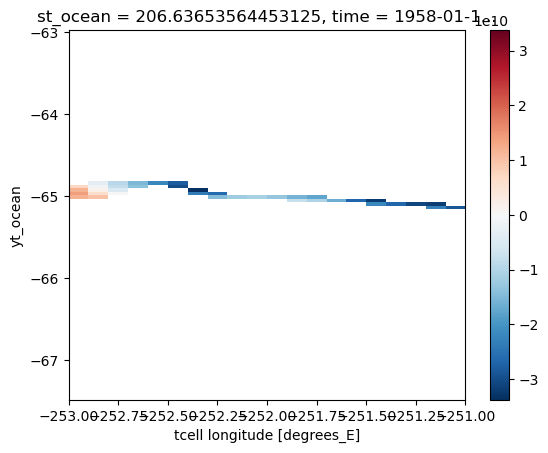

In [81]:
# first time step only:
heat_y[0,0,...].plot()
#heat_y[0,...].plot()

In [82]:
##Because here we need to sum up the whole depth
heat_y = heat_y.sum('st_ocean')

In [83]:
##Because here we need to sum up the whole area to get the real total valeu
heat_y = heat_y.sum('xt_ocean').sum('yt_ocean')

In [84]:
#load the variable
heat_y2000 = heat_y.load()

#### LOAD AND CALCULATE ISOPYCNAL DEPTH

In [55]:
# ORIGINAL
lon_slice  = slice(-253, -251.5)
lat_slice  = slice(-67.5, -63)

temp_iso = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_iso = temp_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

sal_iso = cc.querying.getvar(iaf_cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_iso = sal_iso.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

In [56]:
# calculate density along transect:
# arrays for gsw to use
depth_array = temp_iso*0 + temp_iso.st_ocean
lat_array = temp_iso*0 + temp_iso.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(sal_iso,pressure,sal_iso.xt_ocean,lat_array)
#calculate sigma
sigma0 = gsw.sigma0(salt_abs,temp_iso)

In [57]:
# cut the data BOX 1
lon_slice  = slice(-253, -251.5)
lat_slice  = slice(-67.5, -63)

# topography data:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=16

MAKE MASK FOR BOX 1 offshore in between 1000 and 2000 isopycnals

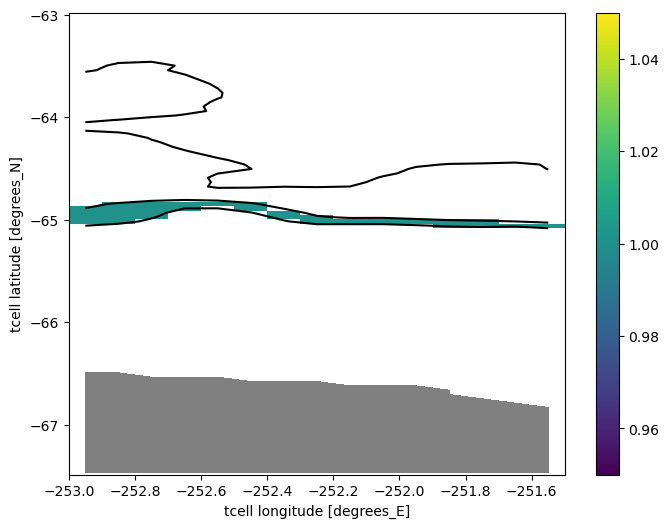

In [58]:
# Mask 

# set to 1 everywhere:
region_mask = ht*0 +1

# mask open ocean:
# shelf masking:
contour_file = np.load('/g/data/jk72/ns3783/Antarctic_slope_contour_10002000m.npz')
shelf_mask = contour_file['temp_mask']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

region_mask = region_mask * shelf_mask.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)


plt.figure(figsize=(8,6))
region_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[1000,2000,3000],colors='k')
#plt.xlim(-275,-245)
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

In [59]:
#apply the mask
sigma0_off = sigma0*region_mask
sigma0_off = sigma0_off.where(sigma0_off!=0)

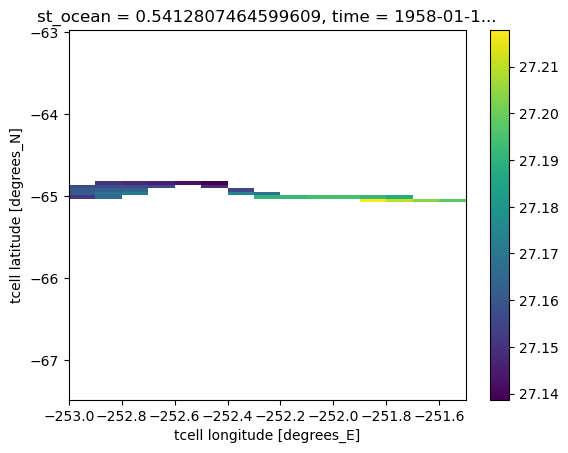

In [60]:
# first time step only:
sigma0_off[0,0,...].plot()

In [61]:
#load
sigma0_off=sigma0_off.load()

Incorporating Adele's method of calculating isopycnals.
Old method works fine, but averaging across lat/lon first means that your final depth values will be limited to values of st_ocean (i.e. quite discrete and widely spaced).
Try to find first depth where density > rho_thresh (27.82 looks like it might be around 500-600 m, i.e. at the depth of shelf break) at each lat/lon position, then average these depths after over lat/lon, which should make the final depth values have more variable values.

Using only the isopycnals that had the highest correlations with previous variables 27.82 and 27.83

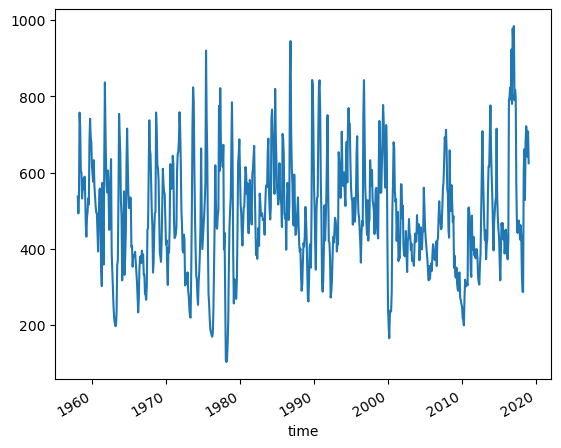

In [62]:
rho_thresh = 27.82

# mask density where < rho_thresh:
sigma0_off_mask = sigma0_off.where(sigma0_off>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0_off*0 + sigma0_off.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0_off>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

# now average that minimum depth over lat and lon:
min_depth_avg = min_depth.mean('xt_ocean').mean('yt_ocean')
min_depth_avg.plot()

#rename the isopycnal
iso2782_dth=min_depth_avg

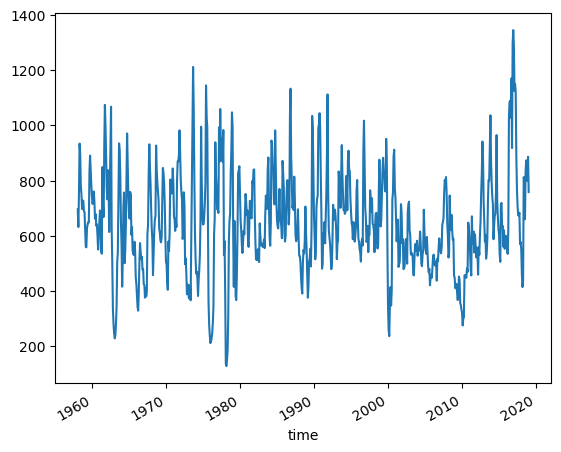

In [63]:
rho_thresh = 27.83

# mask density where < rho_thresh:
sigma0_off_mask = sigma0_off.where(sigma0_off>rho_thresh)
# check this worked:
#sigma0_off_mask[0,:,:,0].plot()

# Now find first depth where sigma0_off_mask is not masked:
depth_array = sigma0_off*0 + sigma0_off.st_ocean
# mask depth array using density threshold:
depth_array_masked = depth_array.where(sigma0_off>rho_thresh)
# find minimum depth at each lat,lon location:
min_depth = depth_array_masked.min(dim='st_ocean')

# now average that minimum depth over lat and lon:
min_depth_avg = min_depth.mean('xt_ocean').mean('yt_ocean')
min_depth_avg.plot()

#rename the isopycnal
iso2783_dth=min_depth_avg

In [64]:
#they are still xarrays until I load them
#iso278_dth=iso278_dth.load()
iso2782_dth=iso2782_dth.load()
iso2783_dth=iso2783_dth.load()
#iso2784_dth=iso2784_dth.load()
#iso2785_dth=iso2785_dth.load()

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [18]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

#### Detrend time series

In [85]:
# Note we need to first detrend the data:
temp_400m_zad = detrend_dim(temp_400m_za,'time')
temp_box1_off2000_zad = detrend_dim(temp_box1_off2000_za,'time')

heat_y2000_d = detrend_dim(heat_y2000,'time')

iso2782_d = detrend_dim(iso2782_dth,'time')
iso2783_d = detrend_dim(iso2783_dth,'time')

ekman_con_adY = detrend_dim(ekman_conY,'time')
ekman_con_adX = detrend_dim(ekman_conX,'time')

asc_Y_d = detrend_dim(asc_heat_y,'time')
asc_X_d = detrend_dim(asc_heat_x,'time')

u_speed = detrend_dim(u_speed_old_za,'time')

#### Apply Rolling Mean 

In [86]:
temp_400m_zadr = temp_400m_zad.rolling(time=12, center=True).mean()
temp_box1_off2000_zadr = temp_box1_off2000_zad.rolling(time=12, center=True).mean()

heat_y2000_dr = heat_y2000_d.rolling(time=12, center=True).mean()

iso2782_dr = iso2782_d.rolling(time=12, center=True).mean()
iso2783_dr = iso2783_d.rolling(time=12, center=True).mean()

ekman_con_adrY = ekman_con_adY.rolling(time=12, center=True).mean()
ekman_con_adrX = ekman_con_adX.rolling(time=12, center=True).mean()

asc_Y_dr = asc_Y_d.rolling(time=12, center=True).mean()
asc_X_dr = asc_X_d.rolling(time=12, center=True).mean()

u_speed_dr = u_speed.rolling(time=12, center=True).mean()

### CORRELATIONS JUST FOR EKMAN & Tbox1

In [68]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(ekman_con_adrY,temp_400m_zadr)
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(ekman_con_adrX,temp_400m_zadr)


print('Cor T400 vs Ekman Y',cor1)
print('Cor T400 vs Ekman X',cor2)


Cor T400 vs Ekman Y <xarray.DataArray ()>
array(-0.2561918)
Cor T400 vs Ekman X <xarray.DataArray ()>
array(-0.24856681)


### CORRELATIONS JUST FOR EKMAN & ISO depth

In [69]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(iso2782_dr,ekman_con_adrY)
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(iso2783_dr,ekman_con_adrY)

cov1b,cor1b,slope1b,intercept1b,pval1b,stderr1b = lag_linregress_3D(iso2782_dr,ekman_con_adrX)
cov2b,cor2b,slope2b,intercept2b,pval2b,stderr2b = lag_linregress_3D(iso2783_dr,ekman_con_adrX)

print('Cor ISO 82 vs Ekman Y',cor1)
print('Cor ISO 83 vs Ekman Y',cor2)
print('Cor ISO 82 vs Ekman X',cor1b)
print('Cor ISO 83 vs Ekman X',cor2b)

Cor ISO 82 vs Ekman Y <xarray.DataArray ()>
array(-0.01253486)
Cor ISO 83 vs Ekman Y <xarray.DataArray ()>
array(0.0425495)
Cor ISO 82 vs Ekman X <xarray.DataArray ()>
array(0.15977379)
Cor ISO 83 vs Ekman X <xarray.DataArray ()>
array(0.11668053)


### CORRELATIONS JUST FOR ASC_heat & Tbox1



In [70]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(asc_Y_dr,temp_400m_zadr)
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(asc_X_dr,temp_400m_zadr)


print('Cor T400 vs ASC Y',cor1)
print('Cor T400 vs ASC X',cor2)


Cor T400 vs ASC Y <xarray.DataArray ()>
array(-0.15542663)
Coordinates:
    yt_ocean  float64 -65.31
Cor T400 vs ASC X <xarray.DataArray ()>
array(-0.51298325)
Coordinates:
    yt_ocean  float64 -65.18


### CORRELATIONS JUST FOR ASC_heat & iso

In [71]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(iso2782_dr,asc_Y_dr )
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(iso2783_dr,asc_Y_dr )

cov1b,cor1b,slope1b,intercept1b,pval1b,stderr1b = lag_linregress_3D(iso2782_dr,asc_X_dr )
cov2b,cor2b,slope2b,intercept2b,pval2b,stderr2b = lag_linregress_3D(iso2783_dr,asc_X_dr )

print('Cor ISO 82 vs ASC Y',cor1)
print('Cor ISO 83 vs ASC Y',cor2)
print('Cor ISO 82 vs ASC X',cor1b)
print('Cor ISO 83 vs ASC X',cor2b)

Cor ISO 82 vs ASC Y <xarray.DataArray ()>
array(-0.02020717)
Coordinates:
    yt_ocean  float64 -65.31
Cor ISO 83 vs ASC Y <xarray.DataArray ()>
array(-0.07016277)
Coordinates:
    yt_ocean  float64 -65.31
Cor ISO 82 vs ASC X <xarray.DataArray ()>
array(0.68044789)
Coordinates:
    yt_ocean  float64 -65.18
Cor ISO 83 vs ASC X <xarray.DataArray ()>
array(0.47624394)
Coordinates:
    yt_ocean  float64 -65.18


### CORRELATIONS JUST FOR ASC_speed vs TBox1 and iso

In [72]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(u_speed_dr,temp_400m_zadr)
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(u_speed_dr,iso2782_dr)
cov3,cor3,slope3,intercept3,pval3,stderr3 = lag_linregress_3D(u_speed_dr,iso2783_dr)

print('Cor ASC SPEED vs BOX 1',cor1)
print('Cor ASC SPEED vs iso 82',cor2)
print('Cor ASC SPEED vs iso 83',cor3)


Cor ASC SPEED vs BOX 1 <xarray.DataArray ()>
array(0.28799909)
Coordinates:
    yu_ocean  float64 -64.99
Cor ASC SPEED vs iso 82 <xarray.DataArray ()>
array(-0.55939385)
Coordinates:
    yu_ocean  float64 -64.99
Cor ASC SPEED vs iso 83 <xarray.DataArray ()>
array(-0.43807902)
Coordinates:
    yu_ocean  float64 -64.99


In [98]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(iso2782_dr,asc_X_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -10 :  <xarray.DataArray ()>
array(0.09981628)
Coordinates:
    yt_ocean  float64 -65.18
lag -9 :  <xarray.DataArray ()>
array(0.15053747)
Coordinates:
    yt_ocean  float64 -65.18
lag -8 :  <xarray.DataArray ()>
array(0.20681613)
Coordinates:
    yt_ocean  float64 -65.18
lag -7 :  <xarray.DataArray ()>
array(0.2676856)
Coordinates:
    yt_ocean  float64 -65.18
lag -6 :  <xarray.DataArray ()>
array(0.33130374)
Coordinates:
    yt_ocean  float64 -65.18
lag -5 :  <xarray.DataArray ()>
array(0.3964109)
Coordinates:
    yt_ocean  float64 -65.18
lag -4 :  <xarray.DataArray ()>
array(0.46141063)
Coordinates:
    yt_ocean  float64 -65.18
lag -3 :  <xarray.DataArray ()>
array(0.52471261)
Coordinates:
    yt_ocean  float64 -65.18
lag -2 :  <xarray.DataArray ()>
array(0.58264442)
Coordinates:
    yt_ocean  float64 -65.18
lag -1 :  <xarray.DataArray ()>
array(0.63190808)
Coordinates:
    yt_ocean  float64 -65.18
lag 0 :  <xarray.DataArray ()>
array(0.66910067)
Coordinates:
    yt_ocean  float

### CORRELATIONS JUST FOR ASC_heat X vs Ekman

In [101]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(ekman_con_adrY,asc_X_dr)
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(ekman_con_adrX,asc_X_dr)


print('Cor ASC Y vs Ekman Y',cor1)
print('Cor ASC X vs Ekman X',cor2)


Cor ASC Y vs Ekman Y <xarray.DataArray ()>
array(-0.11225237)
Coordinates:
    yt_ocean  float64 -65.18
Cor ASC X vs Ekman X <xarray.DataArray ()>
array(0.2684353)
Coordinates:
    yt_ocean  float64 -65.18


### CORRELATIONS JUST FOR Heat Y vs ASC SPEED and ASC HEAT X

In [96]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(heat_y2000_dr,asc_X_dr)
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(heat_y2000_dr,u_speed_dr)


print('Cor ASC X vs HEAT Y',cor1)
print('Cor ASC SPEED vs HEAT Y',cor2)



Cor ASC X vs HEAT Y <xarray.DataArray ()>
array(-0.49677657)
Coordinates:
    yt_ocean  float64 -65.18
Cor ASC SPEED vs HEAT Y <xarray.DataArray ()>
array(0.25487932)
Coordinates:
    yu_ocean  float64 -64.99


In [104]:
# AA
s=11;
for i in range(-s,0):
    cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(heat_y2000_dr,asc_X_dr,
                                                       lagx=0, lagy=i)

    print('lag', i+1, ': ',cor)

lag -10 :  <xarray.DataArray ()>
array(-0.39437606)
Coordinates:
    yt_ocean  float64 -65.18
lag -9 :  <xarray.DataArray ()>
array(-0.43459457)
Coordinates:
    yt_ocean  float64 -65.18
lag -8 :  <xarray.DataArray ()>
array(-0.47285438)
Coordinates:
    yt_ocean  float64 -65.18
lag -7 :  <xarray.DataArray ()>
array(-0.50886879)
Coordinates:
    yt_ocean  float64 -65.18
lag -6 :  <xarray.DataArray ()>
array(-0.54069923)
Coordinates:
    yt_ocean  float64 -65.18
lag -5 :  <xarray.DataArray ()>
array(-0.56693813)
Coordinates:
    yt_ocean  float64 -65.18
lag -4 :  <xarray.DataArray ()>
array(-0.58590582)
Coordinates:
    yt_ocean  float64 -65.18
lag -3 :  <xarray.DataArray ()>
array(-0.59642943)
Coordinates:
    yt_ocean  float64 -65.18
lag -2 :  <xarray.DataArray ()>
array(-0.59510112)
Coordinates:
    yt_ocean  float64 -65.18
lag -1 :  <xarray.DataArray ()>
array(-0.57954657)
Coordinates:
    yt_ocean  float64 -65.18
lag 0 :  <xarray.DataArray ()>
array(-0.54901246)
Coordinates:
    yt

### CORRELATIONS JUST FOR ASC_speed X vs Ekman

In [102]:
cov1,cor1,slope1,intercept1,pval1,stderr1 = lag_linregress_3D(ekman_con_adrY,u_speed_dr)
cov2,cor2,slope2,intercept2,pval2,stderr2 = lag_linregress_3D(ekman_con_adrX,u_speed_dr)


print('Cor ASC speed vs Ekman Y',cor1)
print('Cor ASC speed vs Ekman X',cor2)

Cor ASC speed vs Ekman Y <xarray.DataArray ()>
array(0.04556387)
Coordinates:
    yu_ocean  float64 -64.99
Cor ASC speed vs Ekman X <xarray.DataArray ()>
array(-0.19344315)
Coordinates:
    yu_ocean  float64 -64.99
